# Predict female behavior from inferred neural population activity

## Ridge regression

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from aux import load_npy
from disp import set_plot
from my_torch import skl_fit_ridge_

cc = np.concatenate

STRAINS = ['NM91', 'ZH23']
PTRAIN = .8
NSPLIT = 30

NRL_MDL = 'ma'  # dynamical neural model

KBHVS = ['FFV_MN', 'FLS_MN', 'MTN_MN', 'FMFV_MN', 'FMLS_MN', 'FFV_SD', 'FLS_SD', 'MTN_SD', 'FMFV_SD', 'FMLS_SD']
WDW_BHVS = [.03, .1, .5, 1, 2, 5, 10, 30, 60, 120, 300, 600, 1200]

FIT_LIN = skl_fit_ridge

ALPHA = 10
FIT_KWARGS = {'alpha': ALPHA}

In [2]:
FSTRAIN = 'data/simple/strains.csv'
FBAKER_FIT_PARAM = f'data/simple/neur/baker_{NRL_MDL}_fit_param.csv'

FPFX_NEUR_BHV = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}/mlv_baker_{NRL_MDL}'
FPFX_BHV_XTD = f'data/simple/behav_xtd/behav_xtd'

FSAVE = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}_{"_".join(STRAINS).lower()}_multi_ridge_alpha_{ALPHA}.npy'

DFBAKER_FIT_PARAM = pd.read_csv(FBAKER_FIT_PARAM)
R_COLS_USE = [f'R_{ir}' for ir in DFBAKER_FIT_PARAM.EXPT_ID]

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()
NTRAIN = int(round(PTRAIN*NTR))

In [ ]:
# loop over variables
save_data = {
    'r2_train': {kbhv: np.nan*np.zeros((len(WDW_BHVS), NSPLIT)) for kbhv in KBHVS},
    'r2_test': {kbhv: np.nan*np.zeros((len(WDW_BHVS), NSPLIT)) for kbhv in KBHVS},
    'khbvs': KBHVS,
    'wdws': WDW_BHVS,
    'ntr': NTR,
    'nsplit': NSPLIT,
    'nr': len(R_COLS_USE),
}

targs = []
for kbhv in KBHVS:
    if kbhv.endswith('MN'):
        targs.extend([(kbhv, wdw) for wdw in WDW_BHVS])
    elif kbhv.endswith('SD'):
        targs.extend([(kbhv, wdw) for wdw in WDW_BHVS[1:]])
        
cols_y = [f'{kbhv}_{wdw}' for kbhv, wdw in targs]
        
# fit regression models
for csplit in range(NSPLIT):
    print(f'\nSplit {csplit}')
    
    irnd = np.random.permutation(NTR)
    idxs_train = ISTRAIN[irnd[:NTRAIN]]
    idxs_test = ISTRAIN[irnd[NTRAIN:]]
    
    rslt = FIT_LIN([FPFX_NEUR_BHV, FPFX_BHV_XTD], R_COLS_USE, cols_y, idxs_train, idxs_test, **FIT_KWARGS)

    for kbhv in KBHVS:
        for cwdw, wdw in enumerate(WDW_BHVS):
            k = f'{kbhv}_{wdw}'
            if k in cols_y:
                save_data['r2_train'][kbhv][cwdw, csplit] = rslt.r2_train[k]
                save_data['r2_test'][kbhv][cwdw, csplit] = rslt.r2_test[k]

np.save(FSAVE, np.array([save_data]))

### Plot test R2 vs smoothing window for each behavioral variable

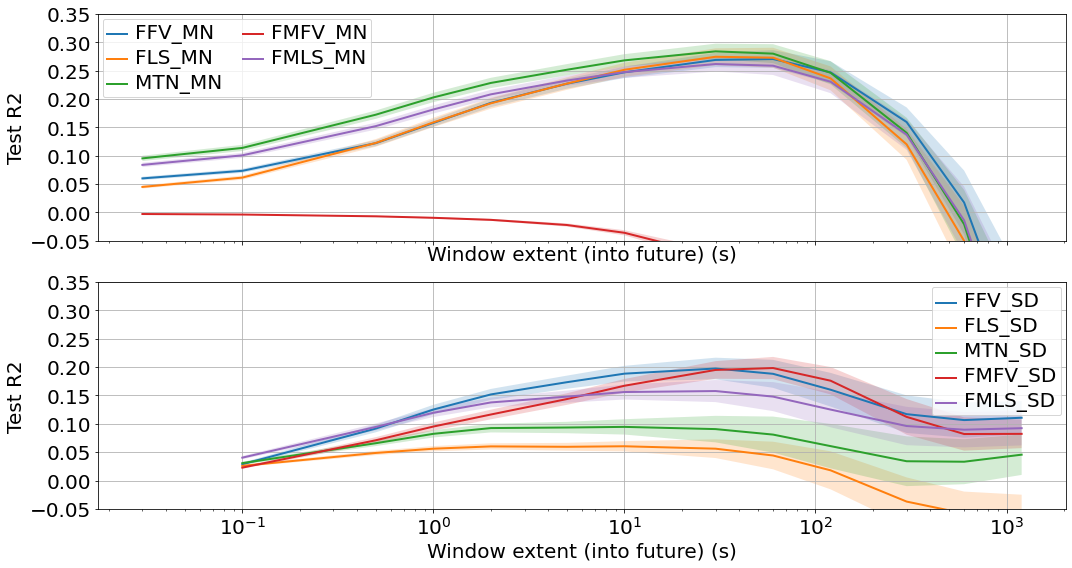

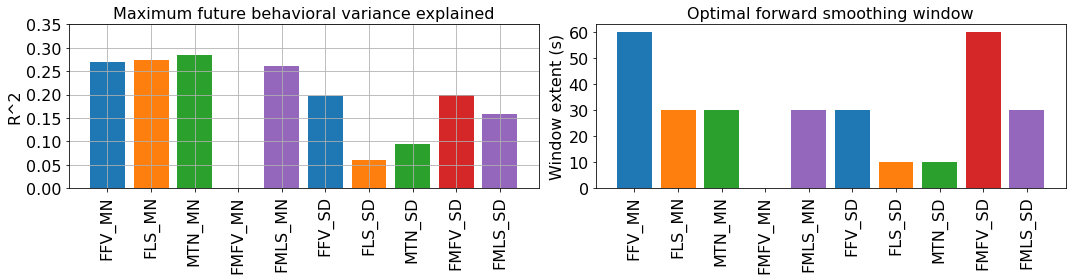

In [3]:
load_data = load_npy(FSAVE)

fig, axs = plt.subplots(2, 1, figsize=(15, 8), tight_layout=True, sharex=True)

hs = []
for kbhv in KBHVS[:5]:
    r2_mn = load_data['r2_test'][kbhv].mean(axis=1)
    r2_sd = load_data['r2_test'][kbhv].std(axis=1)
    r2_sem = r2_sd/np.sqrt(load_data['nsplit'])
    
    hs.append(axs[0].errorbar(WDW_BHVS, r2_mn, lw=2, label=kbhv))
    axs[0].fill_between(WDW_BHVS, r2_mn-r2_sem, r2_mn+r2_sem, alpha=.2)
    
axs[0].legend(handles=hs, ncol=2)
axs[0].set_ylim(-.05, .35)

hs = []
for kbhv in KBHVS[5:]:
    r2_mn = load_data['r2_test'][kbhv].mean(axis=1)
    r2_sd = load_data['r2_test'][kbhv].std(axis=1)
    r2_sem = r2_sd/np.sqrt(load_data['nsplit'])
    
    hs.append(axs[1].errorbar(WDW_BHVS, r2_mn, lw=2, label=kbhv))
    axs[1].fill_between(WDW_BHVS, r2_mn-r2_sem, r2_mn+r2_sem, alpha=.2)
    
axs[1].legend(handles=hs)
axs[1].set_ylim(-.05, .35)

for ax in axs:
    ax.set_xscale('log')
    ax.grid()
    set_plot(ax, x_label='Window extent (into future) (s)', y_label='Test R2', font_size=20)
    

fig, axs = plt.subplots(1, 2, figsize=(15, 4), tight_layout=True)

r2_maxs = np.array([np.nanmax(load_data['r2_test'][kbhv].mean(axis=1)) for kbhv in KBHVS])
for ctr in range(len(KBHVS)//2):
    axs[0].bar([ctr, ctr+len(KBHVS)/2], r2_maxs[[ctr, ctr+len(KBHVS)//2]], align='center')
axs[0].set_ylim(0, .35)
axs[0].grid()
axs[0].set_ylabel('R^2')
axs[0].set_title('Maximum future behavioral variance explained')

tau_maxs = np.array([WDW_BHVS[np.nanargmax(load_data['r2_test'][kbhv].mean(axis=1))] for kbhv in KBHVS])
for ctr in range(len(KBHVS)//2):
    axs[1].bar([ctr, ctr+len(KBHVS)/2], tau_maxs[[ctr, ctr+len(KBHVS)//2]], align='center')
axs[1].set_ylabel('Window extent (s)')
axs[1].set_title('Optimal forward smoothing window')

for ax in axs:
    ax.set_xticks(range(len(KBHVS)))
    ax.set_xticklabels(KBHVS, rotation=90)
    set_plot(ax, font_size=16)

### Paper figure

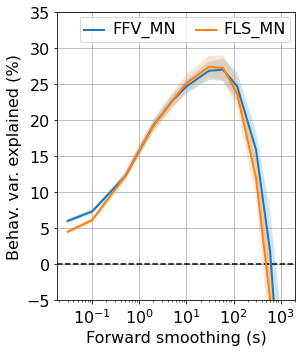

In [18]:
load_data = load_npy(FSAVE)

fig, ax = plt.subplots(1, 1, figsize=(4.3, 5), tight_layout=True, sharex=True)

hs = []
for kbhv in ['FFV_MN', 'FLS_MN']:  #KBHVS[:5]:
    r2_mn = load_data['r2_test'][kbhv].mean(axis=1)
    r2_sd = load_data['r2_test'][kbhv].std(axis=1)
    r2_sem = r2_sd/np.sqrt(load_data['nsplit'])
    
    hs.append(ax.errorbar(WDW_BHVS, 100*r2_mn, lw=2, label=kbhv))
    ax.fill_between(WDW_BHVS, 100*(r2_mn-r2_sem), 100*(r2_mn+r2_sem), alpha=.2)
    
ax.axhline(0, c='k', ls='--')
ax.legend(handles=hs, ncol=2)
ax.set_ylim(-5, 35)

ax.set_xscale('log')
ax.grid()
set_plot(ax, x_label='Forward smoothing (s)', y_label='Behav. var. explained (%)', font_size=16)

fig.savefig('ms/fig2b.svg')

### Loop over ridge regression param alpha

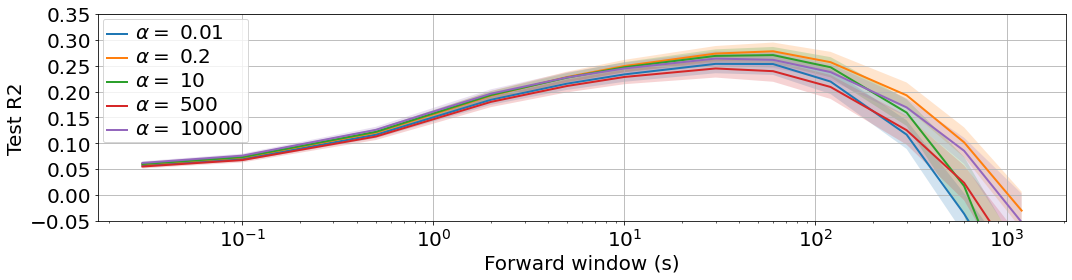

In [4]:
KBHV = 'FFV_MN'
ALPHAS = [.01, .2, 10, 500, 10000]
NTR = 50
WDW_BHVS = [.03, .1, .5, 1, 2, 5, 10, 30, 60, 120, 300, 600, 1200]

fig, ax = plt.subplots(1, 1, figsize=(15, 4), tight_layout=True)

hs = []
for alpha in ALPHAS:
    save_file = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}_nm91_zh23_multi_ridge_alpha_{alpha}.npy'
    load_data = load_npy(save_file)
    
    r2_mn = load_data['r2_test'][KBHV].mean(axis=1)
    r2_sd = load_data['r2_test'][KBHV].std(axis=1)
    r2_sem = r2_sd/np.sqrt(load_data['nsplit'])
    
    hs.append(ax.errorbar(WDW_BHVS, r2_mn, lw=2, label=fr'$\alpha = $ {alpha}'))
    ax.fill_between(WDW_BHVS, r2_mn-r2_sem, r2_mn+r2_sem, alpha=.2)
    
ax.legend(handles=hs)
ax.set_xscale('log')
ax.set_ylim(-.05, .35)
ax.grid()
set_plot(ax, x_label='Forward window (s)', y_label='Test R2', font_size=20)